# Funciones para detección de espiguletas (*spiklets*)

Este cuaderno contiene funciones, graficas y pruebas para la detección automática de espiguletas.
Empezamos por cargar las bibliotecas necesarias de uso general.

In [1]:
push!(LOAD_PATH,".")
using PyPlot, HDF5
using Statistics

In [2]:
using SacaDatos
using Detectores

┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/Detectores.ji for Detectores [top-level]
└ @ Base loading.jl:1190


In [3]:
nomine = "/home/karel/ABFiles/Diana/88101619.h5"

"/home/karel/ABFiles/Diana/88101619.h5"

In [4]:
datos = h5open(nomine, "r");
names(datos)

4-element Array{String,1}:
 "ch0"        
 "channels"   
 "comment"    
 "description"

In [5]:
datos

HDF5 data file: /home/karel/ABFiles/Diana/88101619.h5

In [6]:
constantes, sweps = devuelvedatos(datos, "ch0");
const freq=1/constantes[1];
println("la frequencia de muestreo es ", freq, " kHz." )

la descripcion de tus barridas de datos son las siguientes
HDF5.HDF5Compound{3}[HDF5Compound{3}((0.1, "ms", "mV"), ("dt", "xunits", "yunits"), (Float64, String, String))]
la frequencia de muestreo es 10.0 kHz.


In [7]:
const prevGms=10
const postGms=40
const preG=round(Int, prevGms*freq)
const postG=round(Int, postGms*freq)

400

In [8]:
preG

100

# A partir de aquí viene la numérica sucia: vamos a cargar todos los intervalos de un segundo que a ojo de buen cubero tienen una espiguelta.

In [9]:
sospechosas=[14,16,18,24,28,30,41,44]
ksuspect=[]
subs="section_"
for s in sospechosas
    aux=subs*"$s"
    push!(ksuspect, aux)
end
push!(ksuspect, "section_01")
push!(ksuspect, "section_02")
push!(ksuspect, "section_46")
push!(ksuspect, "section_47")
todas=keys(sweps);

In [10]:
suaves=Dict{String, Array}()
derivadas=Dict{String, Array}()
for subs in todas # aqui estaba ksuspect que era la prueba de las conocidas
    suaves[subs]=suavegauss(sweps[subs])
    derivadas[subs]=derivadadt(suaves[subs])
end


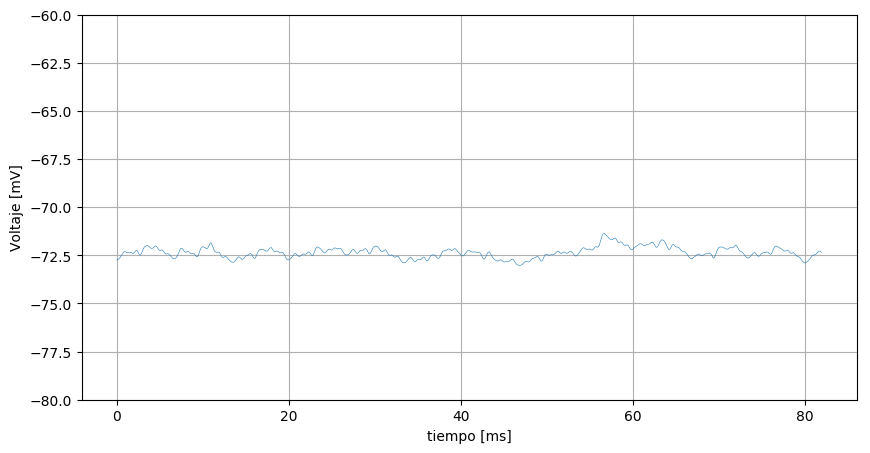

In [22]:
figura=figure(figsize=(10,5))
ylim(-80,-60)

#for subs in keys(suaves)
subs="section_36"

    lala=length(suaves[subs])
rangot=iart(1, lala)  
 plot(rangot,suaves[subs], label=subs, lw=0.4)
#end

xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
#legend()
grid()

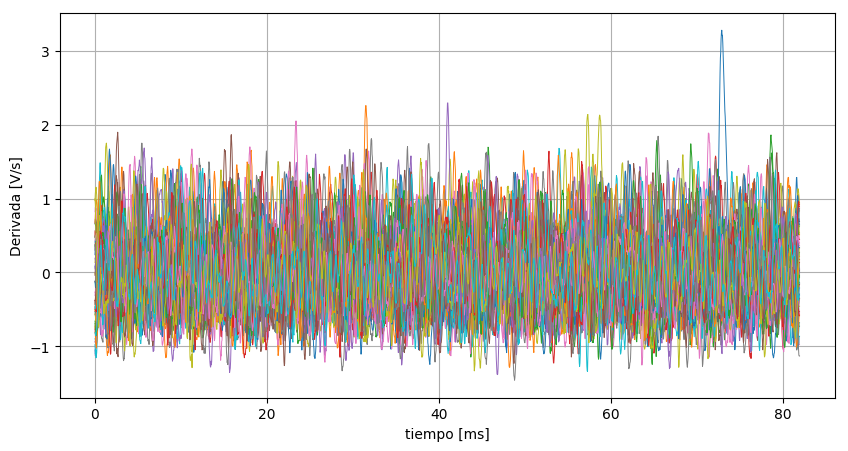

In [12]:
figura=figure(figsize=(10,5))
#ylim(-0.02, 0.5)
for subs in keys(derivadas)
lala=length(derivadas[subs])
rangot=iart(1, lala)    
 plot(rangot,derivadas[subs], label=subs, lw=0.7)
end
xlabel("tiempo [ms]")
ylabel("Derivada [V/s]")
#legend()
grid()

In [14]:
intSS=Dict{String,Dict}()  #intSS es subintervalo del intervalo
for subs in keys(derivadas)
    println(subs)
 intSS[subs]=intervalosP(derivadas[subs], preG=preG, postG=postG, uinf=0.06*freq, usup=0.4*freq)
end

section_44
vamos bien, 1344 1844 1.2678300518100372


UndefVarError: UndefVarError: thres2 not defined

In [ ]:
derivadas

In [ ]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,suaves[subs][rango], label=subs)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
legend()

In [ ]:
figura=figure(figsize=(10,5))
xlim(13000,14000)
#ylim(-0.02,0.1)
  #rango=intSS[subs][1]
plot(derivadas["section_50"])
#plot(suaves["section_50"])

In [ ]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,derivadas[subs][rango], label=subs)
        hlines(0, 0, 50,lw=2)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
grid()
legend()

In [ ]:
(limpia, mocha)=separamochas(intSS);

In [ ]:
ddt=Dict{String, Array}()
for subs in todas # aqui estaba ksuspect que era la prueba de las conocidas
    ddt[subs]=derivadadt(derivadas[subs])    
end

In [ ]:
figura=figure(figsize=(10,5))

title("Segundas Derivadas")

xlim(5,15)
# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,ddt[subs][rango], label=subs)
        hlines(0, 0, 50,lw=2)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
grid()
#legend()

In [ ]:
promSpk=average1(limpia, suaves); # de ahora en adelante asi se sacan promedios sobre intervalos!


In [ ]:
function normCut(datossuave, intervaloslimpios, intervalossospechos)

    a=average1(intervaloslimpios, datossuave) # de ahora en adelante asi se sacan promedios sobre intervalos!
    offset=a[1]
    result=Dict{String,Dict}()
    
   for subs in keys(intervaloslimpios)
    result[subs]=Dict{Int, Array}()
    for j in keys(intervaloslimpios[subs])
         arre=intervalossospechos[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        #normCut[subs][j]=suaves[subs][rango].-(suaves[subs][rango][1]-a[1])
        result[subs][j]=g0(datossuave[subs][rango],a[1]) # g0 es la funcion que empareja el punto de inicio
   
    end
        
    end
    return result
end

In [ ]:
normalized=normCut(suaves, limpia, intSS)

In [ ]:
derivadalimpia=Dict{String, Dict{Int64, Array}}()
for k in keys(normalized)
    derivadalimpia[k]=Dict{Int64,Array}()
    for j in keys(normalized[k])
        derivadalimpia[k][j]=derivadadt(normalized[k][j])
    end
end

In [ ]:
figura=figure(figsize=(10,5))
rangot=0
title("Espiguletas centradas en la maxima taza de cambio")
# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(normalized)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(normalized[subs])
           rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        plot(rangot,normalized[subs][j])
    end
end

 xlabel("ms")
grid()
#plot(a, lw=3)

**NOTA para avanzar**

En la grafica superior, la linea gruesa es el promedio. Nos interesa calcular el tiempo que le lleva levantarse desde
el cambio en la curvatura (suave a muy empinado) hasta el máximo punto de la funcion.

In [ ]:

figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(limpia)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(limpia[subs])
        # tomamos el rango de cada subintervalo sospechoso
        arre=limpia[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        plot(suaves[subs][rango].-(suaves[subs][rango][1]-a[1]), derivadas[subs][rango], lw=0.5)
    end
end
#plot(promSpK[2:end],difProm, lw=5, c="red")

In [ ]:
difProm=derivadadt(promSpk)
ddprom=derivadadt(difProm);

In [ ]:
riset=risetime(difProm)

In [ ]:
#plot(promSpK)
figure(figsize=(12,10))
title("Comparacion datos derivada y dderivada")
ylim(-0.2,0.2)
plot(rangot,difProm)
plot(rangot,ddprom*0.05)
plot(rangot,promSpk.+70)
axvline(x=riset[1]/freq, c="black")
axvline(x=riset[2]/freq, c="black")

grid()

# Usaremos LsqFit y una funcion perrona para hacer ajuste por cachos

In [ ]:
using LsqFit

### Vamos a arreglar esto para que las xzeros no necesiten los bordes... a no se yo creo si los vamos a tener que poner de todas formas

In [ ]:
function lpp(x, xzeros, yzeros, xini, xfin) 

    
    ll=length(xzeros)+1
    
    if ll!=length(yzeros)-1
        error("tu particion no contiene tantos parametros como necesitas \n
            Te puede faltar un y o te sobra un x")
    end
    if (x<=xini || x>=xfin)
        error("x fuera del dominio")
    end
    
     # las m son las pendientes
    mzeros=zeros(ll)
    kzeros=zeros(ll)
    xaux=vcat(xini, xzeros, xfin)   
    #println(xaux)
    
    for k=1:ll
        mzeros[k]=(yzeros[k+1]-yzeros[k])/(xaux[k+1]-xaux[k])
        kzeros[k]=yzeros[k]-mzeros[k]*xaux[k]
    end
    
    y=0
    
    for k=1:ll
        if xaux[k] <= x < xaux[k+1]
     #       println(xaux[k], " ", x, " ", xaux[k+1])
         y = mzeros[k]*x+kzeros[k]
        elseif  x==xfin
                y=yzero[end]
        
        end
    end
    
    return y

end

In [ ]:
plot(rangot[280:end],difProm[280:end])
xlabel("ms")
ylabel("Derivada [mV/ms]")
axhline([0], c="black")
axvline(10, c="black")
axvline(12, c="black")
axvline(13, c="black")
title("inspiracion")
grid()


# AHORA si es en serio:

In [ ]:
ip=round(Int, 10*freq)
ic=findfirst(x->x<0, difProm[250:end])+ip

In [ ]:
yyforfit=difProm[ic:end]
xxfofit=rangot[ic:end];

In [ ]:
xxfofit

In [ ]:
xzeros5=[12,13,15.5]
yzeros5=[-0.0001, -0.4,-0.25, -0.05,-0.0001];


In [ ]:
xi=xxfofit[1]
xf=xxfofit[end]
model5(x,p)=map(xr->lpp(xr, p[1:3], p[4:8], xi, xf),x)

In [ ]:
p_0_5=vcat(xzeros5,yzeros5)

In [ ]:
yys5=map(x->lpp(x, xzeros5, yzeros5,xi,xf), xxfofit[2:end-1]);

In [ ]:
fit5 = curve_fit(model5, xxfofit[2:end-1], yyforfit[2:end-1], p_0_5);

In [ ]:
pp5=fit5.param

In [ ]:
yyfit5=model5(xxfofit[2:end-1],pp5);

Vamos a sacar nuestro $r^2$


In [ ]:
sstot=sum((yyforfit.-mean(yyforfit)).^2)
ssreg=sum((yyfit5.-mean(yyforfit)).^2)
rquad5=1-ssreg/sstot

In [ ]:
xzeros4=[12,15.5]
yzeros4=[-0.001,-0.45, -0.05,-0.001]
p_0_4=vcat(xzeros4,yzeros4)
xi=xxfofit[1]
xf=xxfofit[end]
model4(x,p)=map(xr->lpp(xr, p[1:2], p[3:6], xi, xf),x)

In [ ]:
fit4 = curve_fit(model4, xxfofit[2:end-1], yyforfit[2:end-1], p_0_4)

In [ ]:
typeof(fit4)

In [ ]:
pp4=fit4.param;
yyfit4=model4(xxfofit[2:end-1],pp4);

### Hasta aqui fue con el promedio:
Ahora hay que hacerlo para cada una de las diferentes derivadas.


In [ ]:
ip=round(Int, 10*freq)
ic=findfirst(x->x<0, difProm[250:end])+ip

dictfits=Dict{String,Dict{Int64, Any}}()

# Primero buscamos la lista de los intervalos ejemplo
@time for k in keys(derivadalimpia)
    dictfits[k]=Dict{Int64, Any}()
    for j in keys(derivadalimpia[k])
        aux=derivadalimpia[k][j]
        #el punto donde comienza el ajuste
        ic=findfirst(x->x<0, aux[250:end])+ip
        yyforfit=aux[ic:end]
        xxfofit=rangot[ic:end];
        xi=xxfofit[1]
        xf=xxfofit[end]
        model4(x,p)=map(xr->lpp(xr, p[1:2], p[3:6], xi, xf),x)
        dictfits[k][j]=curve_fit(model4, xxfofit[2:end-1], yyforfit[2:end-1], p_0_4)
    end
end


In [ ]:
for k in keys(dictfits)
    for j in keys(dictfits[k])
        aux=dictfits[k][j]
        ppp=aux.param;
        println(ppp)
        yyfit4=model4(xxfofit[2:end-1],ppp);
        plot(xxfofit[2:end-1], yyfit4)
    end
end

In [ ]:
yyfit4[1:10]

In [ ]:
yys4=map(x->lpp(x, xzeros4, yzeros4,xi,xf), xxfofit[2:end-1]);

In [ ]:
plot(rangot[278:end],difProm[278:end])
plot(xxfofit[2:end-1], yyfit5)
plot(xxfofit[2:end-1], yyfit4)


In [ ]:
sstot=sum((yyforfit.-mean(yyforfit)).^2)
ssreg=sum((yyfit4.-mean(yyforfit)).^2)
rquad4=1-ssreg/sstot

In [ ]:
paso=1/freq
tts=0:paso:50

In [ ]:
freq

In [ ]:
np=pyimport("numpy")

In [ ]:
piezas=np[:piecewise]
piezas

## A partir de aquí estamos guardando datos

In [ ]:
using DelimitedFiles

In [ ]:
datos=hcat(promSpK[2:end],difProm)

In [ ]:
writedlm("../h5files/masterspikelet.dat", datos)

In [ ]:
nota="Esta espiguleta es el promedio de todas las detectadas automaticamente con el experimento  "*nomine

In [ ]:
h5open("../h5files/masterspiklet.h5", "w") do file
   write(file, "voltaje", promSpK[2:end])  # alternatively, say "@write file A"
    write(file, "derivative", difProm)  # alternatively, say "@write file A"
    write(file, "nota", nota)  # alternatively, say "@write file A"
end


In [ ]:

test = h5open("../h5files/masterspiklet.h5", "r");
names(test)

In [ ]:
#using HDF5